# analyseStormEventTypes

Analyse all storm event identified by ML

Running this notebook via a browser rather than directly in VS Code. In a command prompt, run the following:

```
conda activate process
cd <path\to\this\folder>
jupyter notebook
```

This will start the notebook server, and open the folder listing in the default browser. You can then open this notebook and run the code blocks.


In [1]:
%matplotlib inline


from os.path import join as pjoin, exists

import pandas as pd
import numpy as np
from scipy.stats import genpareto
from scipy.optimize import curve_fit
from statsmodels.nonparametric.kde import KDEUnivariate


import seaborn as sns
import matplotlib.pyplot as plt

from stndata import ONEMINUTESTNDTYPE, ONEMINUTESTNNAMES


In [2]:
BASEDIR = r"..\data\allevents"
OUTPUTPATH = pjoin(BASEDIR, "results")
stormdf = pd.read_pickle(pjoin(OUTPUTPATH, "stormclass.pkl"))
allstnfile = r"X:\georisk\HaRIA_B_Wind\data\raw\from_bom\2022\1-minute\HD01D_StationDetails.txt"
allstndf = pd.read_csv(allstnfile, sep=',', index_col='stnNum',
                       names=ONEMINUTESTNNAMES,
                       keep_default_na=False,
                       converters={
                            'stnName': str.strip,
                            'stnState': str.strip,
                            'stnDataStartYear': lambda s: int(float(s.strip() or 0)),
                            'stnDataEndYear': lambda s: int(float(s.strip() or 0))
                        })

In [3]:
trainingstormdf = pd.read_csv(r"..\data\training\visual_storm_types.csv", usecols=[1, 2,3])
trainingstormdf['date'] = pd.to_datetime(trainingstormdf.date)

In [4]:
def loadDailyMaxData(stnNum: int) -> pd.DataFrame:
    """
    Load daily maximum wind gust data for a given station

    :param stnNum: Station identification number
    :type stnNum: int
    :return: `pd.DataFrame` containing daily maximum wind gust data for the station, along with other variables associated with the gust event.
    :rtype: pd.DataFrame
    """
    try:
        df = pd.read_pickle(pjoin(BASEDIR, 'dailymax', f"{stnNum:06d}.pkl"))
    except FileNotFoundError:
        print(f"No data for station {stnNum}")
    df = df.reset_index(drop=False).set_index(['stnNum', 'date'])
    return df

In [5]:
alldflist = []
for stn in allstndf.index:
    if exists(pjoin(BASEDIR, 'dailymax', f"{stn:06d}.pkl")):
        df = loadDailyMaxData(stn)
        alldflist.append(df)
    else:
        print(f"No data for station {stn}")
    
alldf = pd.concat(alldflist)
alldf.reset_index(drop=False, inplace=True)
alldf['date'] = pd.to_datetime(alldf.date)
alldf.set_index(['stnNum', 'date'], inplace=True)

No data for station 87185
No data for station 66198
No data for station 66199
No data for station 66200
No data for station 66201
No data for station 66202
No data for station 66203
No data for station 60168


In [6]:
datadf = stormdf.join(alldf, on=['stnNum', 'date'], how='inner')

In [7]:
datadf[['stnNum', 'stormType', 'datetime']].to_csv(pjoin(OUTPUTPATH,r"visual_storm_types_datetime.csv"))

Storms with a gust wind speed over 150 km/h and a gust ratio > 9.0 (about the 98th percentile of gust ratio values) are considered spurious and reclassified as "Unclassified".

In [8]:
datadf.loc[(datadf.windgust>150) & (datadf.gustratio > 9.0) & (~datadf.stormType.isin(['Spike', 'Unclassified'])), 'stormType'] = 'Unclassified'

Text(0, 0.5, 'Wind gust [km/h]')

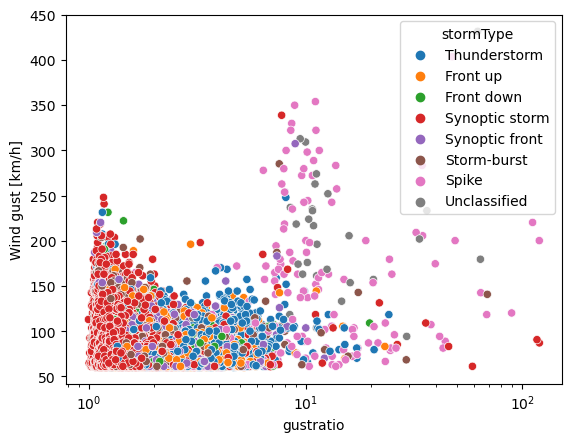

In [9]:
ax=sns.scatterplot(data=datadf, x='gustratio', y='windgust', hue='stormType',
                   hue_order=['Thunderstorm', 'Front up', 'Front down', 
                       'Synoptic storm', 'Synoptic front', 'Storm-burst', 'Spike', 'Unclassified'])
ax.set_xscale('log')
ax.set_ylabel("Wind gust [km/h]")

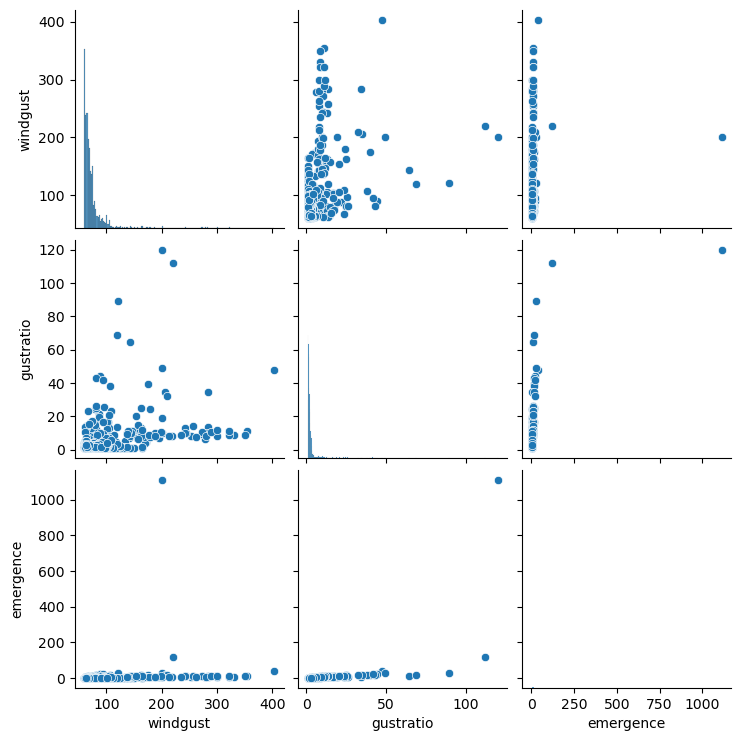

In [10]:
spikes = datadf[datadf.stormType.isin(['Spike'])]
sns.pairplot(spikes[['windgust','gustratio','emergence']], )

In [11]:
tsGust = datadf.loc[datadf.stormType.isin(['Thunderstorm', 'Front up', 'Front down'])]
synGust = datadf.loc[datadf.stormType.isin(['Synoptic storm', 'Synoptic front', 'Storm-burst'])]

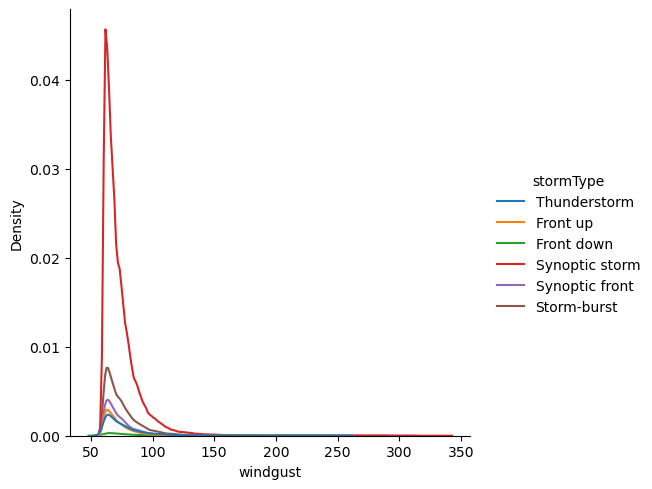

In [12]:
sns.displot(data=datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])],
            x='windgust', hue='stormType', kind='kde',
            hue_order=['Thunderstorm', 'Front up', 'Front down', 
                       'Synoptic storm', 'Synoptic front', 'Storm-burst'])

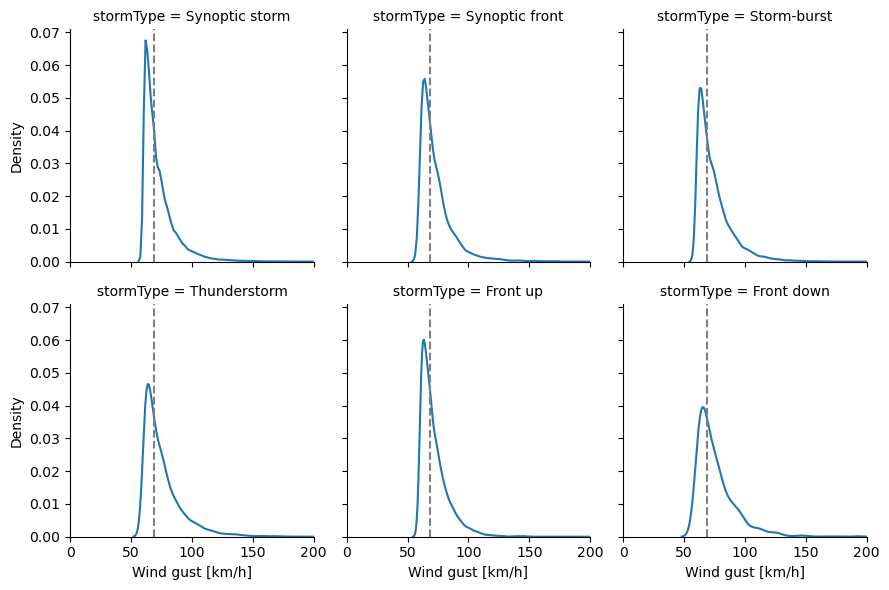

In [13]:
g = sns.FacetGrid(datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])],
                  col='stormType', col_wrap=3, 
                  col_order=
                  ["Synoptic storm", "Synoptic front",
                   "Storm-burst", "Thunderstorm",
                   "Front up", "Front down"])
g.map(sns.kdeplot, 'windgust', )
g.refline(x=datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])]["windgust"].median())
g.set_axis_labels("Wind gust [km/h]", "Density")
g.set(xlim=(0, 200))
g.tight_layout()

In [14]:
# Median wind gust by storm type

datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])].groupby('stormType')['windgust'].apply(np.median)

stormType
Front down        72.0
Front up          68.4
Storm-burst       70.2
Synoptic front    68.4
Synoptic storm    68.4
Thunderstorm      70.2
Name: windgust, dtype: float64

Front down and Thunderstorm consistenly produce more extreme events, as demonstrated by the 99th percentile value for each storm type. 

In [15]:
datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])].groupby('stormType')['windgust'].apply(np.quantile, [0.5, 0.99])

stormType
Front down        [72.0, 132.13800000000015]
Front up                       [68.4, 112.0]
Storm-burst                    [70.2, 127.8]
Synoptic front                 [68.4, 131.4]
Synoptic storm                 [68.4, 127.8]
Thunderstorm                   [70.2, 139.0]
Name: windgust, dtype: object

In [16]:
month_to_season_dct = {
    1: 'DJF', 2: 'DJF',
    3: 'MAM', 4: 'MAM', 5: 'MAM',
    6: 'JJA', 7: 'JJA', 8: 'JJA',
    9: 'SON', 10: 'SON', 11: 'SON',
    12: 'DJF'
}

cleandf = datadf.loc[~datadf.stormType.isin(['Spike', 'Unclassified'])]
cleandf['season'] = [month_to_season_dct.get(dt.month) for dt in cleandf.date]

C:\Users\u08461\AppData\Local\Temp\ipykernel_20728\1378809175.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleandf['season'] = [month_to_season_dct.get(dt.month) for dt in cleandf.date]


In [17]:
cleandf.to_csv(pjoin(OUTPUTPATH, "seasonal_storm_classes.csv"))
cleandf.to_pickle(pjoin(OUTPUTPATH, "seasonal_storm_classes.pkl"))
datadf.to_csv(pjoin(OUTPUTPATH, "all_classified_storms.csv"))
datadf.to_pickle(pjoin(OUTPUTPATH, "all_classified_storms.pkl"))

We consider the rate of storm types by season, aggregated across the country. We expect there to be seasonal differences between northern and southern climate zones, so this is not a definitive breakdown of the seasonal storm types. 

In [18]:
pd.pivot_table(cleandf, index=['stormType'], columns=['season'], aggfunc='count')['DD']

season,DJF,JJA,MAM,SON
stormType,,,,
Front down,649,154,213,344
Front up,3676,1301,1656,2179
Storm-burst,5184,8055,5524,7337
Synoptic front,4535,2275,2329,3997
Synoptic storm,31012,30988,24153,36464
Thunderstorm,3098,1834,1651,2617


How many storm types for a given location? Here we choose Sydney Airport (66037)

In [19]:
cleandf.reset_index(drop=False).set_index(['stnNum', 'date']).loc[[66037]]['stormType'].value_counts()

Synoptic storm    817
Storm-burst       139
Synoptic front    101
Thunderstorm       37
Front up           33
Front down          7
Name: stormType, dtype: int64

In [20]:
def empiricalPDF(data):
    """
    Evaluate a probability density function using kernel density
    estimation for input data.

    :param data: :class:`numpy.ndarray` of data values.

    :returns: PDF values at the data points.
    """
    sortedmax = np.sort(data)
    kde = KDEUnivariate(sortedmax)
    kde.fit()
    try:
        res = kde.evaluate(sortedmax)
    except MemoryError:
        res = np.zeros(len(sortedmax))
    return res

def fitGPD(x, mu, xi, sigma):
    emppdf = empiricalPDF(x)
    popt, pcov = curve_fit(lambda x, xi, sigma: genpareto.pdf(x, xi, loc=mu, scale=sigma), np.sort(x), emppdf, (xi, sigma))
    return popt, pcov

We now fit a generalised pareto distribution (GPD) to each station and each broad group of storm type (i.e. convective & non-convective). 

Use a fixed shape parameter (approach used in AS/NZS 1170.2), and set the initial location parameter to match the minimum wind speed (60 km/h)

In [21]:
tsgpdparams = pd.DataFrame(columns=['mu', 'xi', 'sigma'])
for stn, tmpdf in tsGust.groupby('stnNum'):
    x = tmpdf['windgust'].values
    xi, mu, sigma = genpareto.fit(np.sort(x),fc=0.1, loc=x.min())
    # print(f"STN: {stn} | mu: {mu}, xi: {xi}, sigma {sigma}")
    tsgpdparams.loc[stn] = pd.Series({'mu': mu, 'xi': xi, 'sigma': sigma}, name=stn)

In [22]:
tsgpdparams

,mu,xi,sigma
1006,61.200000,0.1,12.670371
1007,61.200000,0.1,10.923186
1019,61.200000,0.1,4.832785
1020,61.200000,0.1,6.002795
2012,61.199998,0.1,8.485149
...,...,...,...
300004,61.200000,0.1,15.975623
300017,61.200000,0.1,47.692970
300050,61.200000,0.1,24.708571
300055,63.000000,0.1,16.632032


In [23]:
syngpdparams = pd.DataFrame(columns=['mu', 'xi', 'sigma'])
for stn, tmpdf in synGust.groupby('stnNum'):
    x = tmpdf['windgust'].values
    xi, mu, sigma = genpareto.fit(np.sort(x),fc=0.1, loc=x.min())
    syngpdparams.loc[stn] = pd.Series({'mu': mu, 'xi': xi, 'sigma': sigma}, name=stn)

As a demonstration, we plot the fitted GP distributions for convective/non-convective wind gusts for an individual station, using the fixed shape parameter. 

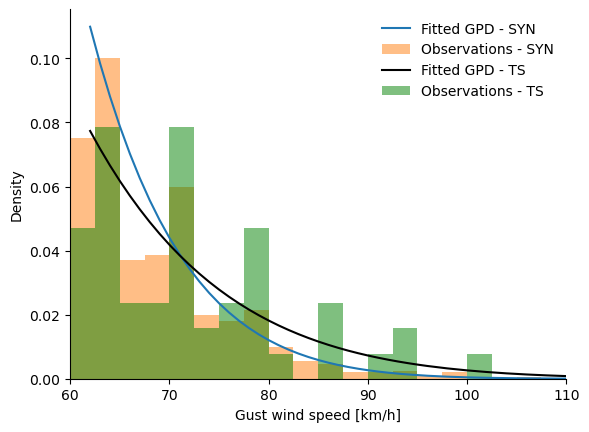

In [24]:
swspd = np.sort(synGust[synGust.stnNum==9021]['windgust'].values)
sshp, sloc, sscl = genpareto.fit(swspd, fc=-0.1, loc=swspd.min())
x = np.arange(62, 200)
fig, ax = plt.subplots(1, 1)
ax.plot(x, genpareto.pdf(x, sshp, loc=sloc, scale=sscl), label="Fitted GPD - SYN")
ax.hist(swspd, density=True, alpha=0.5, label="Observations - SYN", bins=np.arange(60, 200, 2.5))
ax.set_xlim(60, 10*(int(swspd.max()/10) + 1))
ax.set_xlabel("Gust wind speed [km/h]")
ax.set_ylabel("Density")
ax.legend(frameon=False)

twspd = np.sort(tsGust[tsGust.stnNum==9021]['windgust'].values)
tshp, tloc, tscl = genpareto.fit(twspd, fc=-0.1, loc=twspd.min())
x = np.arange(62, 200)
ax.plot(x, genpareto.pdf(x, tshp, loc=tloc, scale=tscl), color='k', label="Fitted GPD - TS")
ax.hist(twspd, density=True, color='g', alpha=0.5, label="Observations - TS",
        bins=np.arange(60, 200, 2.5))
ax.set_xlim(60, 10*(int(twspd.max()/10) + 1))
ax.set_xlabel("Gust wind speed [km/h]")
ax.set_ylabel("Density")
ax.legend(frameon=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)



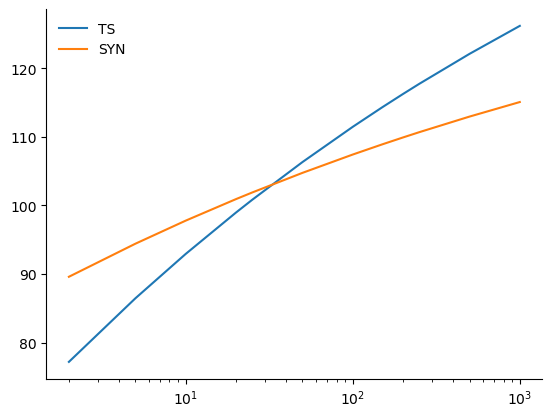

In [25]:
intervals = np.array([2, 5, 10, 20, 25, 50, 100, 150, 200, 250, 500, 1000])
npyr = 365.25
srate = float(len(swspd))/(25*npyr)
trate = float(len(twspd))/(25*npyr)
trp = tloc + (tscl / tshp) * (np.power(intervals * npyr * trate, tshp) - 1.)
srp = sloc + (sscl / sshp) * (np.power(intervals * npyr * srate, sshp) - 1.)

fig, ax = plt.subplots(1, 1)
ax.semilogx(intervals, trp, label="TS")
ax.semilogx(intervals, srp, label='SYN')
ax.legend(frameon=False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)